<a href="https://colab.research.google.com/github/la-becca/Alura/blob/main/Apache_Spark_Com_Python/Challenge_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução

A imobiliária InsightPlaces, situada na cidade do Rio de Janeiro, está enfrentando dificuldades para alugar e vender imóveis. Em uma pesquisa de como empresas semelhantes operam no mercado, a InsightPlaces percebeu que esse problema pode estar relacionado aos valores dos imóveis e às recomendações que faz.

Dentro desse contexto, como podemos definir de forma eficiente os preços dos imóveis lidando com grande volume de dados? É importante recomendar imóveis utilizando outro critério? O que precisa ser feito?

Você faz parte do time de Ciência de Dados e Big Data da InsightPlaces e ficou responsável por auxiliar no processo de análise de dados dos imóveis localizados em alguns bairros da cidade do Rio de Janeiro.

Esse projeto tem algumas etapas como: ler e fazer o tratamento do histórico dos preços de imóveis no Rio de Janeiro, construir um modelo de regressão para precificar imóveis e criar um recomendador de imóveis. Para cada uma dessas etapas vamos utilizar a ferramenta PySpark que oferece uma melhor performance ao trabalharmos com grandes volumes de dados.

#Dados
A InsightPlaces disponibilizou os dados contidos no banco de dados quanto às informações de preços de imóveis da cidade do Rio de Janeiro. Para acessá-los, basta clicar no link abaixo:

[Base de dados - InsightPlaces](https://caelum-online-public.s3.amazonaws.com/challenge-spark/semana-1.zip)

[Dicionário de dados](https://github.com/millenagena/Challenge-Data-Science-Alura-2ed/blob/main/1-Transformando-os-dados/dados/README.md)

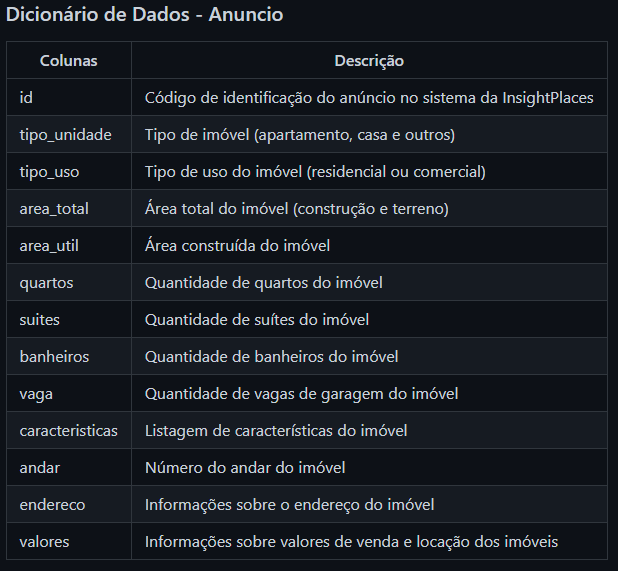


#Imports

In [1]:
# instalar as dependências
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Iniciando com Spark") \
    .getOrCreate()

spark

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Carregando dados

In [6]:
path='/content/drive/MyDrive/Colab Notebooks/Dados/dataset_bruto_json/dataset_bruto.json'
data=spark.read.json(path)
data.show(5)

+--------------------+--------------------+--------------------+
|             anuncio|             imagens|             usuario|
+--------------------+--------------------+--------------------+
|{0, [], [16], [0]...|[{39d6282a-71f3-4...|{9d44563d-3405-4e...|
|{0, [], [14], [0]...|[{23d2b3ab-45b0-4...|{36245be7-70fe-40...|
|{0, [1026], [1026...|[{1da65baa-368b-4...|{9dc415d8-1397-4d...|
|{0, [120], [120],...|[{79b542c6-49b4-4...|{9911a2df-f299-4a...|
|{0, [3], [3], [0]...|[{e2bc497b-6510-4...|{240a7aab-12e5-40...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



#Explorando o dataset

In [8]:
#Número de linhas 
data.count()

89083

In [13]:
#Número de colunas principais
print(len(data.columns))

3


In [7]:
#Schema
data.printSchema()

root
 |-- anuncio: struct (nullable = true)
 |    |-- andar: long (nullable = true)
 |    |-- area_total: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- area_util: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- banheiros: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- caracteristicas: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- endereco: struct (nullable = true)
 |    |    |-- bairro: string (nullable = true)
 |    |    |-- cep: string (nullable = true)
 |    |    |-- cidade: string (nullable = true)
 |    |    |-- estado: string (nullable = true)
 |    |    |-- latitude: double (nullable = true)
 |    |    |-- longitude: double (nullable = true)
 |    |    |-- pais: string (nullable = true)
 |    |    |-- rua: string (nullable = true)
 |    |    |-- zona: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-

#Transformando dados

In [19]:
import pyspark.sql.functions as F

#Transformar cada campo da coluna 'anuncio' em uma coluna separada
data_split=data.select(F.col("anuncio.*"))
data_split.printSchema()
data_split.show()

root
 |-- andar: long (nullable = true)
 |-- area_total: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- area_util: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- banheiros: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- endereco: struct (nullable = true)
 |    |-- bairro: string (nullable = true)
 |    |-- cep: string (nullable = true)
 |    |-- cidade: string (nullable = true)
 |    |-- estado: string (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |    |-- pais: string (nullable = true)
 |    |-- rua: string (nullable = true)
 |    |-- zona: string (nullable = true)
 |-- id: string (nullable = true)
 |-- quartos: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- suites: array (nullable = true)
 |    |-- element: long (c

In [25]:
data_split.cube('tipo_anuncio').count().show()

+------------+-----+
|tipo_anuncio|count|
+------------+-----+
|        null|89083|
|       Usado|88827|
|  Lançamento|  256|
+------------+-----+



In [26]:
data_split.cube('tipo_unidade').count().show()

+------------+-----+
|tipo_unidade|count|
+------------+-----+
|        null|89083|
|      Outros|11963|
| Apartamento|66801|
|        Casa|10319|
+------------+-----+



In [27]:
data_split.cube('tipo_uso').count().show()

+-----------+-----+
|   tipo_uso|count|
+-----------+-----+
|       null|89083|
|Residencial|84541|
|  Comercial| 4542|
+-----------+-----+



In [33]:
#Filtros no dataset nas colunas: tipo_anuncio, tipo_unidade, tipo_uso
data_filtrado = data_split.where("tipo_anuncio='Usado' and tipo_unidade='Apartamento' and tipo_uso='Residencial'")
data_filtrado.show(5)

+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|andar|area_total|area_util|banheiros|     caracteristicas|            endereco|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|             valores|
+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|    3|      [43]|     [43]|      [1]|[Academia, Churra...|{Paciência, 23585...|d2e3a3aa-09b5-45a...|    [2]|    []|       Usado| Apartamento|Residencial| [1]|[{245, null, Vend...|
|    2|      [42]|     [42]|      [1]|[Churrasqueira, P...|{Paciência, 23585...|085bab2c-87ad-452...|    [2]|    []|       Usado| Apartamento|Residencial| [1]|[{0, 0, Venda, 15...|
|    1|      [41]|     [41]|      [1]|[Portaria 24h, Co...|{Guaratiba, 23036...|18d22cbe-1b86-4

In [34]:
data_filtrado.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_total: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- area_util: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- banheiros: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- endereco: struct (nullable = true)
 |    |-- bairro: string (nullable = true)
 |    |-- cep: string (nullable = true)
 |    |-- cidade: string (nullable = true)
 |    |-- estado: string (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |    |-- pais: string (nullable = true)
 |    |-- rua: string (nullable = true)
 |    |-- zona: string (nullable = true)
 |-- id: string (nullable = true)
 |-- quartos: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- suites: array (nullable = true)
 |    |-- element: long (c

In [44]:
#Transformar as colunas dos cômodos dos imóveis de listas para inteiros
data_1 = data_filtrado\
            .withColumn('quartos', data_filtrado['quartos'][0])\
            .withColumn('suites', data_filtrado['suites'][0])\
            .withColumn('banheiros', data_filtrado['banheiros'][0])\
            .withColumn('vaga', data_filtrado['vaga'][0])\
            .withColumn('area_total', data_filtrado['area_total'][0])\
            .withColumn('area_util', data_filtrado['area_util'][0])
data_1.show(5)

+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|andar|area_total|area_util|banheiros|     caracteristicas|            endereco|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|             valores|
+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|    3|        43|       43|        1|[Academia, Churra...|{Paciência, 23585...|d2e3a3aa-09b5-45a...|      2|  null|       Usado| Apartamento|Residencial|   1|[{245, null, Vend...|
|    2|        42|       42|        1|[Churrasqueira, P...|{Paciência, 23585...|085bab2c-87ad-452...|      2|  null|       Usado| Apartamento|Residencial|   1|[{0, 0, Venda, 15...|
|    1|        41|       41|        1|[Portaria 24h, Co...|{Guaratiba, 23036...|18d22cbe-1b86-4

In [51]:
#Tratamento de informações sobre localização
data_2 = data_1.select('*', F.col("endereco.bairro"), F.col("endereco.zona")).drop('endereco')
data_2.printSchema()
data_2.show()

root
 |-- andar: long (nullable = true)
 |-- area_total: string (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: long (nullable = true)
 |-- valores: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- condominio: string (nullable = true)
 |    |    |-- iptu: string (nullable = true)
 |    |    |-- tipo: string (nullable = true)
 |    |    |-- valor: string (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+--

In [61]:
#Transformar cada campo da coluna "valores" em uma coluna separada
data_3 = data_2.withColumn('valores', data_2['valores'][0]).select('*', F.col("valores.*")).drop('valores')
data_3.show(5)

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+---------+----------+----------+----+-----+-----+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|   bairro|      zona|condominio|iptu| tipo|valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+---------+----------+----------+----+-----+-----+
|    3|        43|       43|        1|[Academia, Churra...|d2e3a3aa-09b5-45a...|      2|  null|       Usado| Apartamento|Residencial|   1|Paciência|Zona Oeste|       245|null|Venda|15000|
|    2|        42|       42|        1|[Churrasqueira, P...|085bab2c-87ad-452...|      2|  null|       Usado| Apartamento|Residencial|   1|Paciência|Zona Oeste|         0|   0|Venda|15000|
|    1|        41|       41|        1|[Portaria 24h, Co...|1

In [62]:
#Filtrando apenas informações do tipo Venda
data_4 = data_3.where("tipo='Venda'")
data_4.show(5)

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+---------+----------+----------+----+-----+-----+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|   bairro|      zona|condominio|iptu| tipo|valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+---------+----------+----------+----+-----+-----+
|    3|        43|       43|        1|[Academia, Churra...|d2e3a3aa-09b5-45a...|      2|  null|       Usado| Apartamento|Residencial|   1|Paciência|Zona Oeste|       245|null|Venda|15000|
|    2|        42|       42|        1|[Churrasqueira, P...|085bab2c-87ad-452...|      2|  null|       Usado| Apartamento|Residencial|   1|Paciência|Zona Oeste|         0|   0|Venda|15000|
|    1|        41|       41|        1|[Portaria 24h, Co...|1

In [64]:
#Salvando os dados parquet
data_4.write.parquet(
    path='/content/drive/MyDrive/Colab Notebooks/Dados/dataset_tratado/parquet',
    mode='overwrite'
)

In [65]:
spark.stop()